In [2]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
from decode_fish.engine.microscope import add_pos_noise
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.predict import window_predict
from decode_fish.funcs.evaluation import matching
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
from decode_fish.funcs.routines import *
from decode_fish.engine.point_process import *

from omegaconf import open_dict
from hydra import compose, initialize

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

# Training (data taken from starfish MERFISH analysis notebook)
https://spacetx-starfish.readthedocs.io/en/mcai-notebooks-sphinxgallery/gallery/pipelines/merfish_pipeline.html

Load base config. train.yaml contains all hyperparameters, merfish_starfish contains dataset specific information (e.g. number of channels, number of genes, dataset location etc.) that stay fixed across experiments.

In [82]:
initialize(config_path="config")

hydra.initialize()

In [288]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_starfish"])
cfg = OmegaConf.create(cfg)

Make dataset specific changes

<details><summary>Notes on the MERFISH generative model: **click to expand!** </summary>
    
The basic observation model is given by:
$$Y=DXG+b+\epsilon$$
where Y is the observed multi-channel data, D is the codebook, X is the distribution of transcripts (i.e. the target), G is the PSF and b is additive baseline activity.

Going into more detail these are some additional properties that could be accounted for:
    
1) The data is usually recorded in multiple color channels (here 2, 2 color channels * 8 rounds = 16 bits)
   * This introduces chromatic aberration between the two sets of channels
   * PSFs might be different too
   * We learn separate PSFs (genm.PSF.ncols) as well as chromatic aberration (training.mic.par_grads.color_shifts). 
    
2) There might be small spatial shifts between the color channels (even after alignment during preprocessing)
   * We learn these shifts (training.mic.par_grads.channel_shifts)
    
3) Scaling between channels and colors can vary widely and normalizing it is crucial for performance
   * We can either try to equalize intensities in preprocessing or learn them (training.mic.par_grads.channel_facs)
    
4) As noted in the [supplement](https://www.pnas.org/doi/10.1073/pnas.1612826113) "spot centroids for the same RNA varied in position by ∼100 nm in different imaging rounds, possibly because of the finite cellular volume occupied by each RNA"
   * During simulation we randomly shift the positions across channels for each transcript (genm.microscope.pos_noise_xy / pos_noise_z)
    
5) Just looking at the data we often observe spots that are only visible in single channels and can therefore not be attributed to any code.
   * We simulate such spurious spots with genm.emitter_noise
    
6) At transcription sites we might observe very high local densities of transcripts. (Though these seemed more relevant for smFISH data than for MERFISH?)
   * We simulate such local clusters with the settings in genm.foci. 
    
</details>

In [289]:
# project and run_name set the directories where the trained models are saved, as well as the structure in wandb.ai
cfg.output.project = 'MERFISH_starfish'
cfg.run_name ='MERFISH_sweep_gen_8'
cfg.output.group='MERFISH_sweep_gen_8'

cfg.data_path.image_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/thetascaled_stack.tiff'

'''Simulation parameters'''
# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.genm.foci.n_foci_avg = 0
# Lower and upper limit of emitters simulated per focus
cfg.genm.foci.n_mol_range: [5,40]                       
    
# Sets the emitter density (range of uniform probabilities for a voxel to contain a transcript)
cfg.genm.prob_generator.low = 0.01
cfg.genm.prob_generator.high = 0.1

# Sets the intensity distribution of the simulation (parametrizes of a gamma distribution)
cfg.genm.intensity_dist.int_conc = 3.
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = 1.

# Multiplicative overall scaling. Should be adjusted to match the oberved intensity values
cfg.genm.microscope.scale = 800
cfg.genm.PSF.mode = 'bicubic'
cfg.genm.microscope.norm = 'escort'

# Background values are sampled by smoothing the real data
cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9
cfg.sim.roi_mask.percentile = 30

# In addition to real emitters that are sampled from the codebook (and are visible in multiple channels) we sample spurious 'fake' emitters that only show up in a single channel (to make the network more robust)
cfg.genm.emitter_noise.rate_fac = 3.

# Noise on the coordinates of individual transcripts across channels
cfg.genm.pos_noise.pos_noise_z = 0.04
cfg.genm.pos_noise.pos_noise_xy = 0.4
cfg.training.z_sig_fac = 1.

cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MFsf_psf1n.tif'

cfg.genm.noise.theta = [0.1] * 8 + [0.2] * 8
    
'''Performance tracking'''

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'
cfg.output.log_interval = 500
cfg.evaluation.code_stats.enabled = True

'''Network architecture'''
cfg.network._target_ = 'decode_fish.engine.model.UnetDecodeNoBn_2S'
cfg.network.f_maps = 256
cfg.network.depth = 2
cfg.network.chrom_map = True
cfg.genm.microscope.col_shifts_enabled = True

'''Training'''
cfg.training.bs = 20
cfg.training.net.opt.lr = 5e-4
cfg.training.psf.norm_reg = 0.

cfg.training.num_iters = 100000

cfg.training.mic.enabled = False

cfg.training.schedule = [10000, 3000, 5000, 2000, 5000, 2000, 5000, 2000, 10000]

cfg.training.mic.sched.step_size = 2000
cfg.training.psf.sched.step_size = 2000
cfg.training.mic.mean_diff = True

cfg.training.psf.opt.lr = 0.00005
cfg.training.mic.opt.lr = 0.001
cfg.training.psf.l1_reg = 0.0003
cfg.genm.exp_type.const_theta_sim = True

cfg.genm.phasing = 0.1

cfg.training.net.bl_loss = 'mse'
cfg.training.net.bl_loss_scale = .003

cfg.sim.bg_estimation.shuffle_ch = True
cfg.training.pred_em_noise = False
cfg.genm.exp_type.em_noise_inf = True

cfg.data_path.model_init = None
# cfg.data_path.model_init  = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_6/const_theta_0foci/checkpoint/'

# Which parts of the model to train
cfg.training.mic.par_grads.channel_facs = True
cfg.training.mic.par_grads.channel_shifts = True
cfg.training.mic.par_grads.theta_par = False
cfg.training.mic.par_grads.psf_vol = True
cfg.training.mic.par_grads.color_shifts = True
cfg.training.mic.par_grads.z_facs = True
cfg.training.mic.par_grads.sc_fac = True

cfg.training.mic.ch_facs_as_theta = False

Save cfg

In [290]:
fname = f'config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_sweep_gen_8'

The config file is all you need to train your model. There is a couple of options.  
* You can load the config in the nbs/13_train.ipynb notebook and run all cells. This will continuously produce plots that let you track the training progress.  
* The recommended method is to execute the exeriment in your terminal: "python decode_fish/train.py +experiment=msp300_1"  If you enabled wandb tracking you will get a link for this run.
* You change parameters of your parameters in the command line. For example if you want to run training with a bigger batch size you could execute:  
"python decode_fish/train.py +experiment=MERFISH_sweep_gen_1 training.bs=50 run_name=bs_50"


In [183]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_rtx -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev2/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name} run_name=2Sx output.group={cfg.run_name}')

bsub -gpu "num=1" -q gpu_rtx -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_sweep_gen_7 run_name=2Sx output.group=MERFISH_sweep_gen_7


Load data and codebook, show first channel

In [184]:
img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])
print(img.shape)
_ = plot_3d_projections(img[0][None], size=5, proj_func=np.max)

torch.Size([1, 16, 1, 2048, 2048])


ValueError: cannot select an axis to squeeze out which has size not equal to one

Estimate noise scale

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [185]:
n_foci = cfg.genm.foci.n_foci_avg
cfg.genm.foci.n_foci_avg = 0
img_5d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.genm.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [186]:
import tifffile
thetas = np.zeros(img_5d.shape[:2])
vol_mean1 = img_5d[:,:8].mean()
vol_mean2 = img_5d[:,8:].mean()

for i in tqdm(range(len(img_5d))):
    mask = 1 - get_roi_mask(img_5d[i], pool_size=(10,10,10), percentile=50)
    for c in range(img_5d.shape[1]):

        bg_est = hydra.utils.instantiate(cfg.sim.bg_estimation.smoothing)(img_5d[i][c,:,:,:].to('cuda'))
        theta = estimate_noise_scale(img_5d[i][c][mask.nonzero()], bg_est[mask.nonzero()], percentile=98, plot=False)
        thetas[i,c] = theta
        
# ch_facs = 1/thetas.mean(0)
# scaled_vol = img_5d * ch_facs[:,None,None,None]
# scaled_vol[:,:8] *= vol_mean1/scaled_vol[:,:8].mean()
# scaled_vol[:,8:] *= vol_mean2/scaled_vol[:,8:].mean()
# tifffile.imsave('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/thetascaled2_stack.tiff', data=np.array(scaled_vol, dtype=np.float32))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.22s/it]


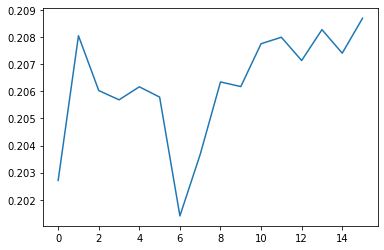

In [187]:
plt.plot(thetas.mean(0))

This function allows you to visually compare the recorded data and the simulations generated with the given config.  

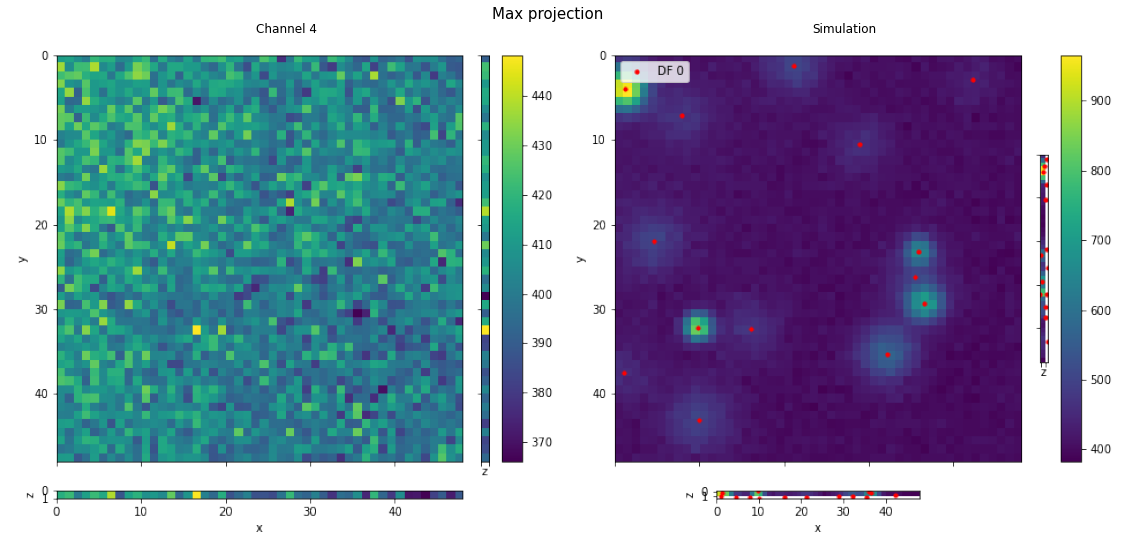

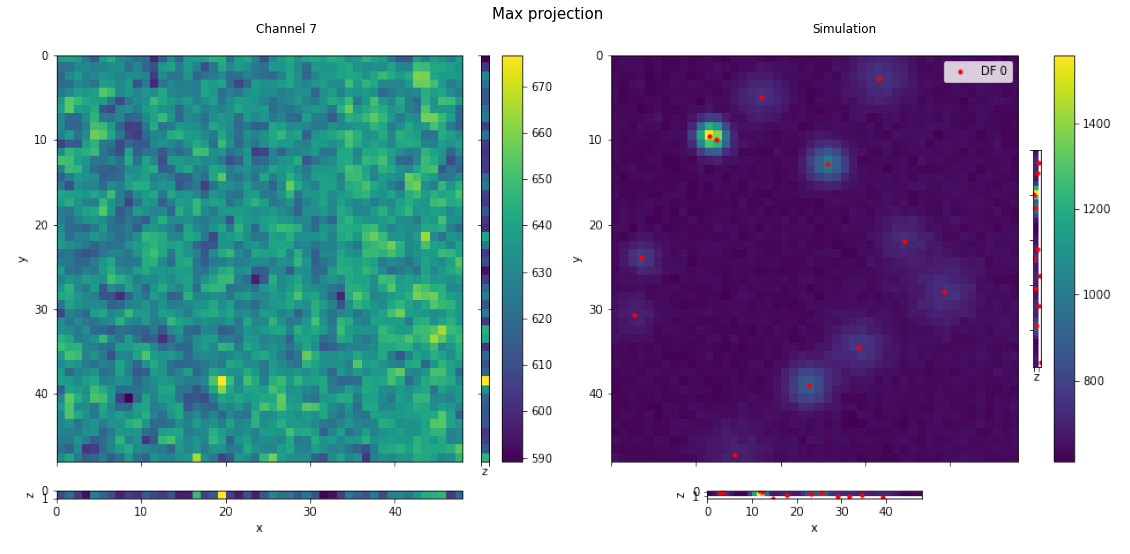

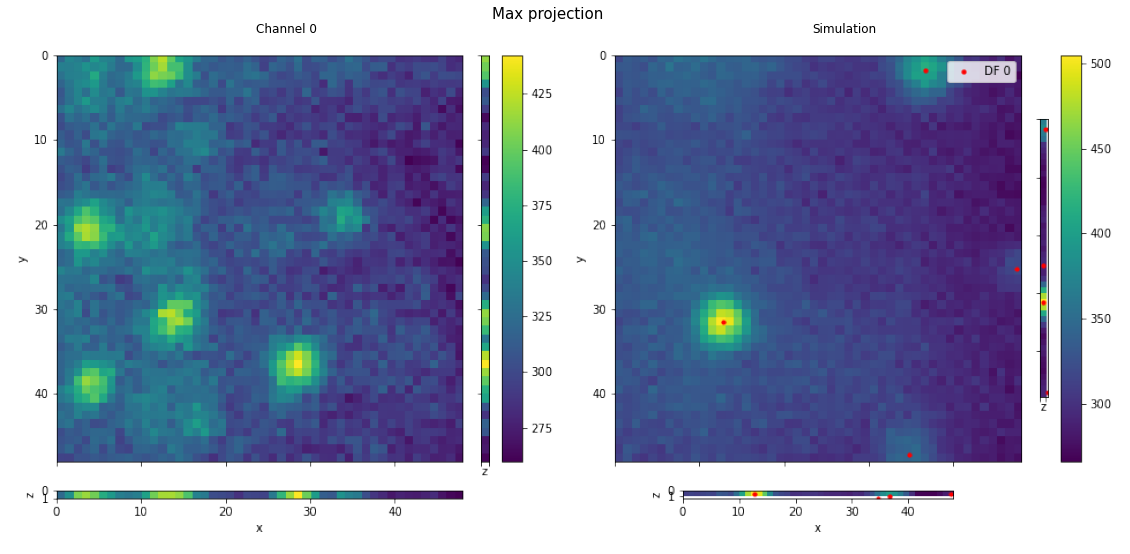

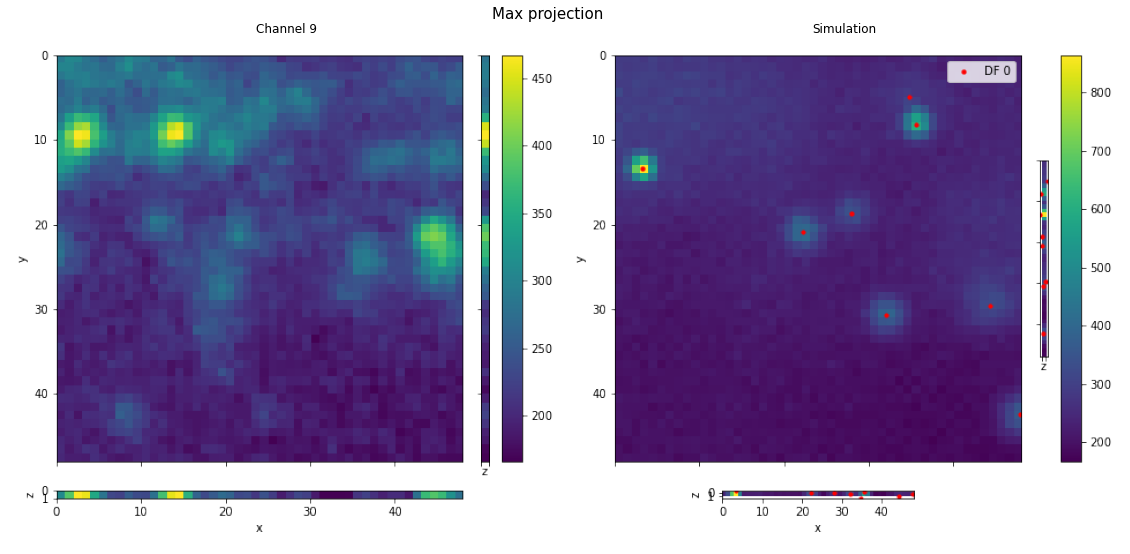

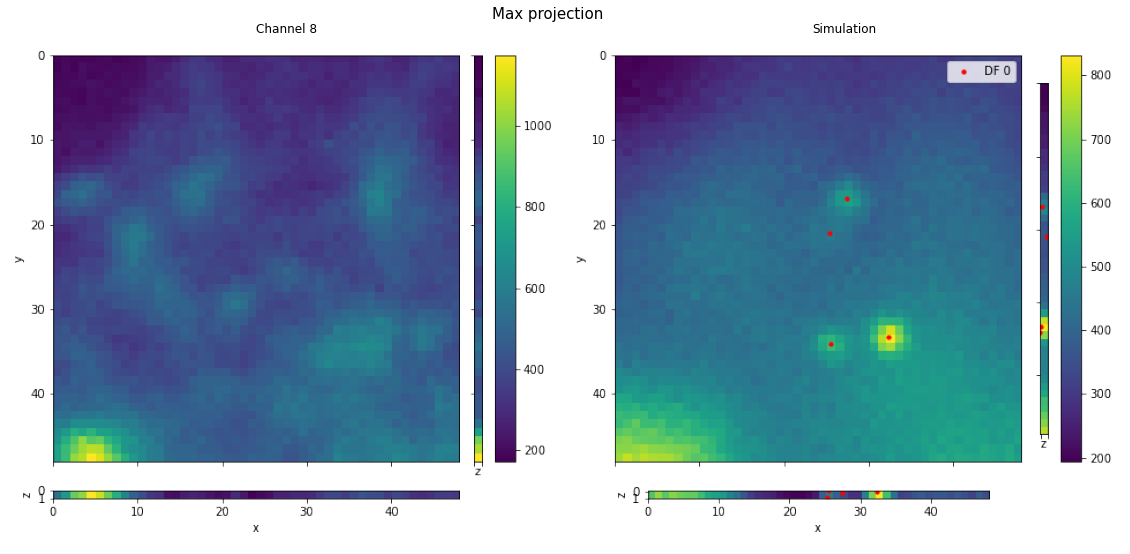

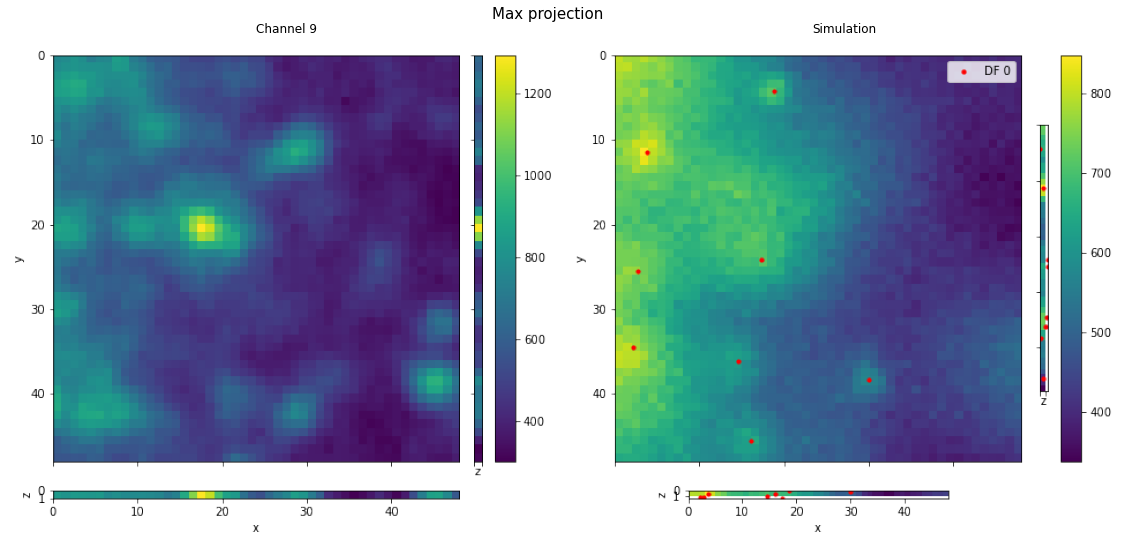

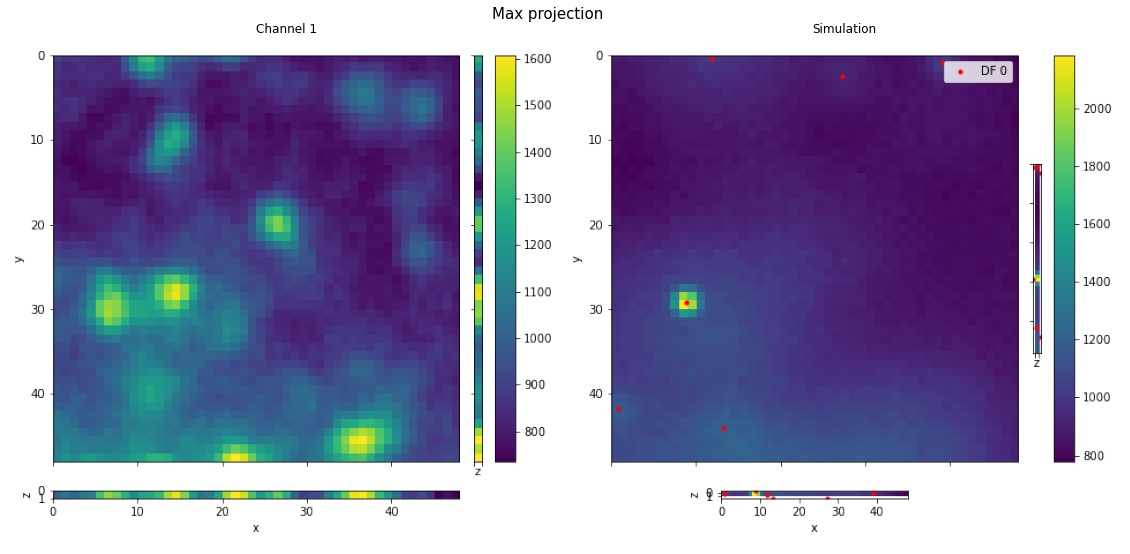

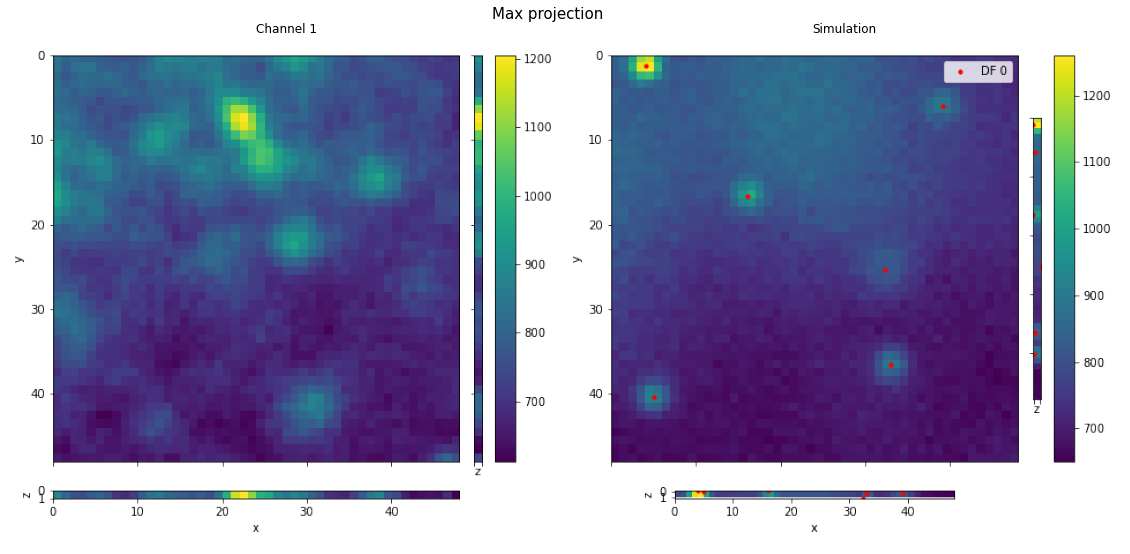

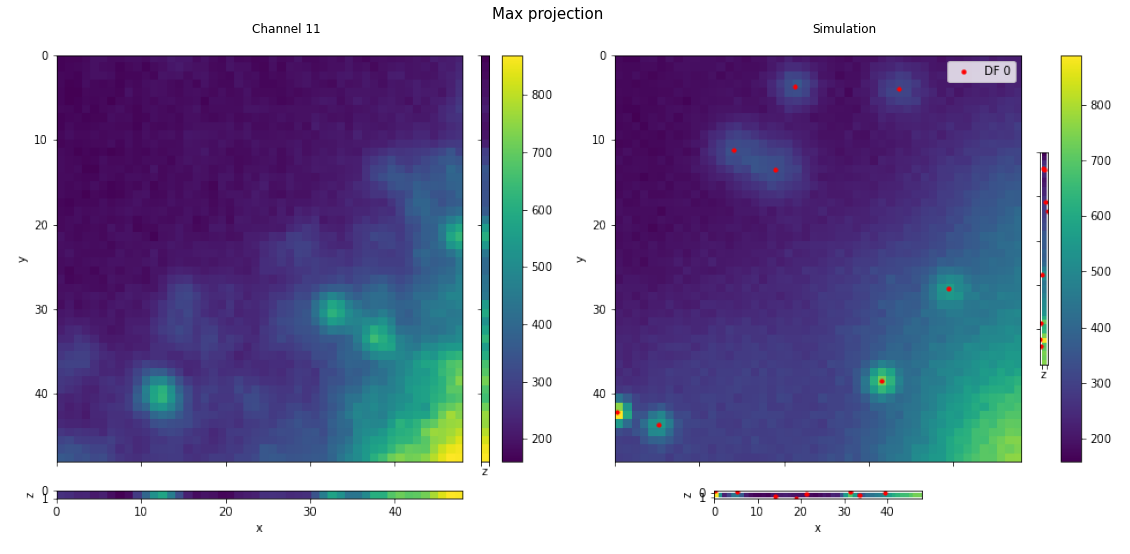

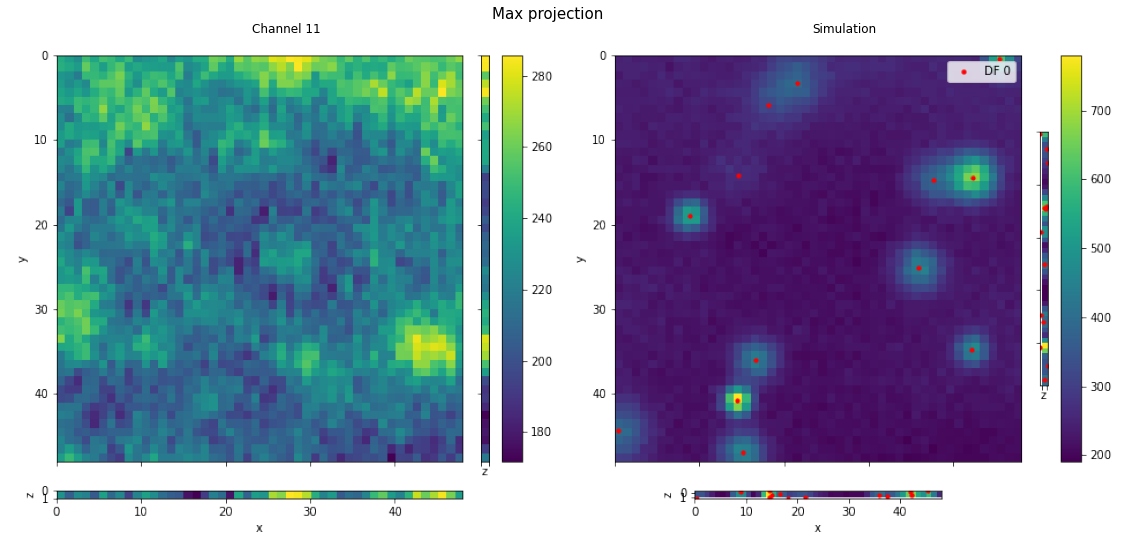

In [170]:
point_process = PointProcessUniform(**cfg.genm.intensity_dist, n_channels=cfg.genm.exp_type.n_channels, sim_z=True, slice_rec=True, codebook=None, int_option=1)
get_simulation_statistics(decode_dl, micro, point_process, int_threshold=0.1, samples=10)

# Evaluation

In [293]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_8/target_mean:True///train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_3/norm:escortxlr:0.0001/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/MERFISH_sweep_gen_4/high:0.1/train.yaml')


In [294]:
codebook, targets = get_starfish_codebook()

In [295]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(codebook)
if cfg.genm.exp_type.em_noise_inf: post_proc.codebook = torch.tensor(expand_codebook(torch.tensor(codebook)))

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


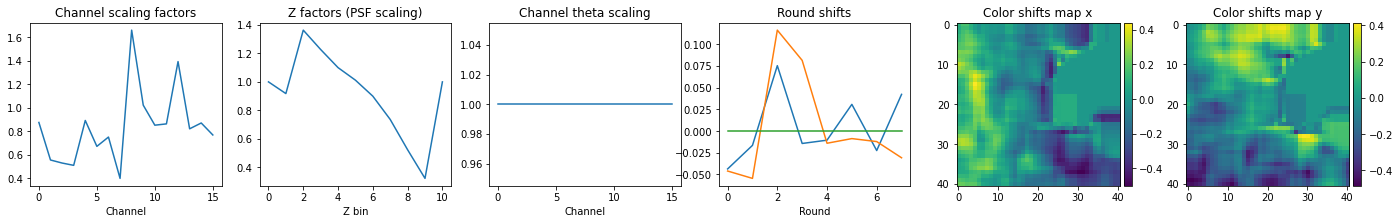

In [296]:
plot_micro_pars(micro)

Plot mean projections of the PSF before and after optimizing it during training

In [269]:
# Normalize
# Detection efficiency vs z. 
# limit z range depending on data
# add noise emitter channels 
# 16 channels RGB kodieren

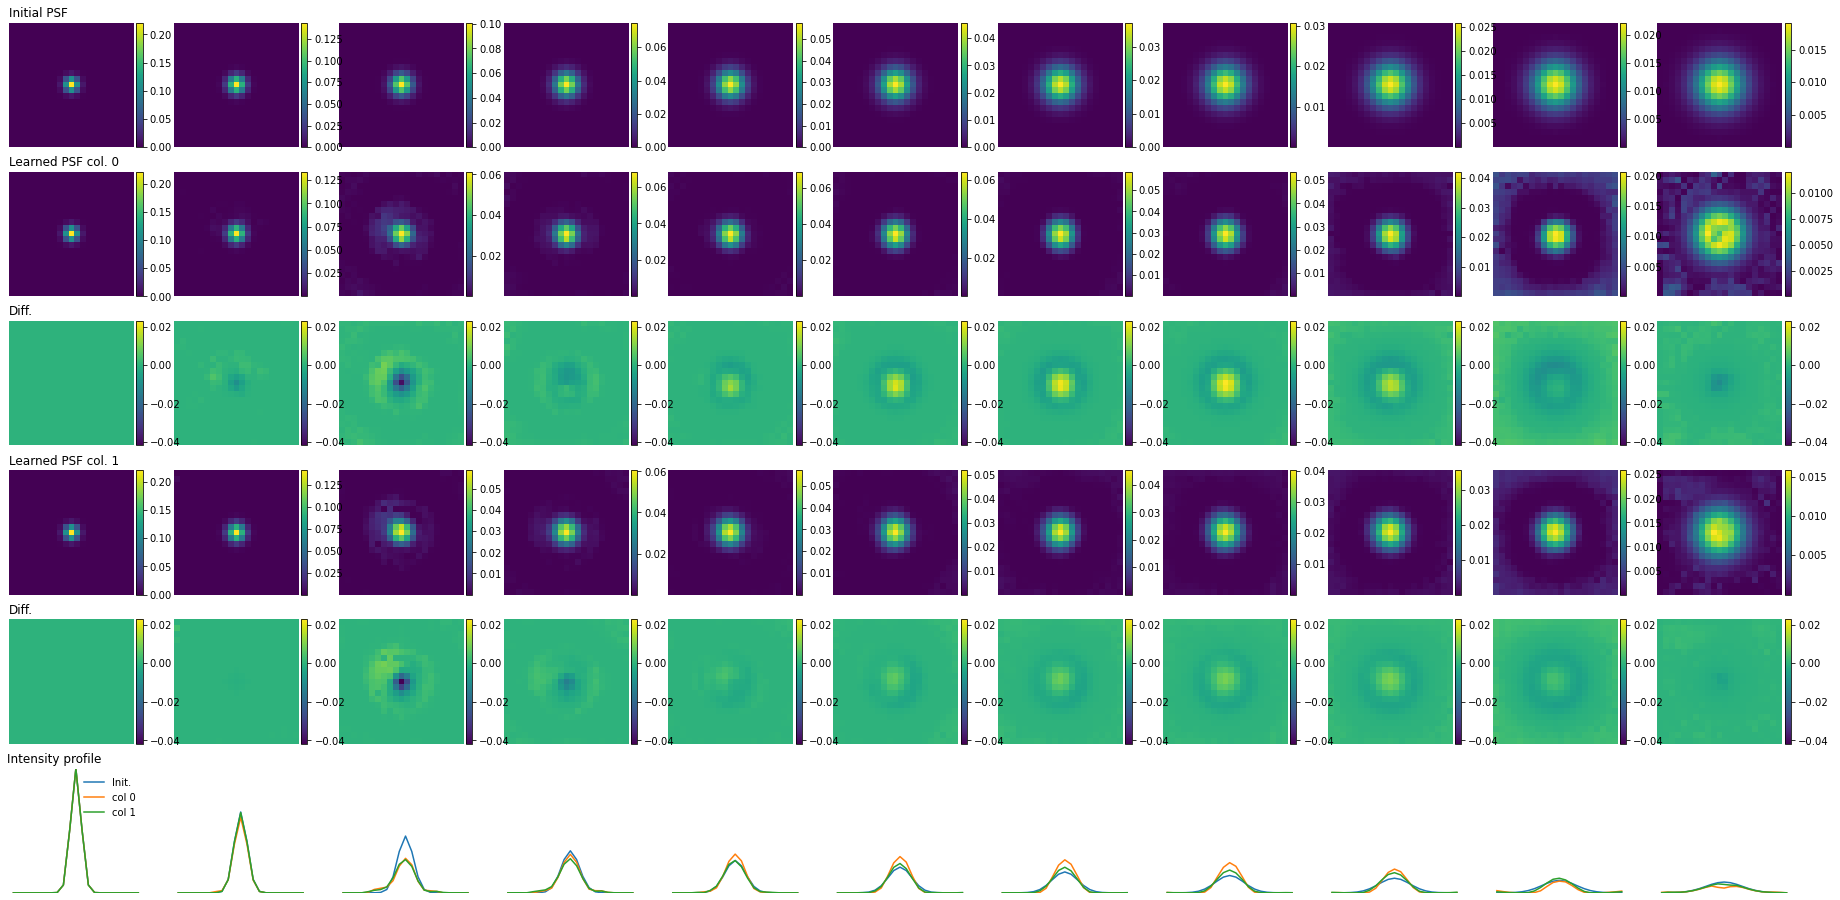

In [350]:
plot_slice_psf_pars(micro, normed=True)

Sample random sub volumes and overlay them with predictions,  also shows the reconstruction from applying the microscope and PSF model to those predictions.

13


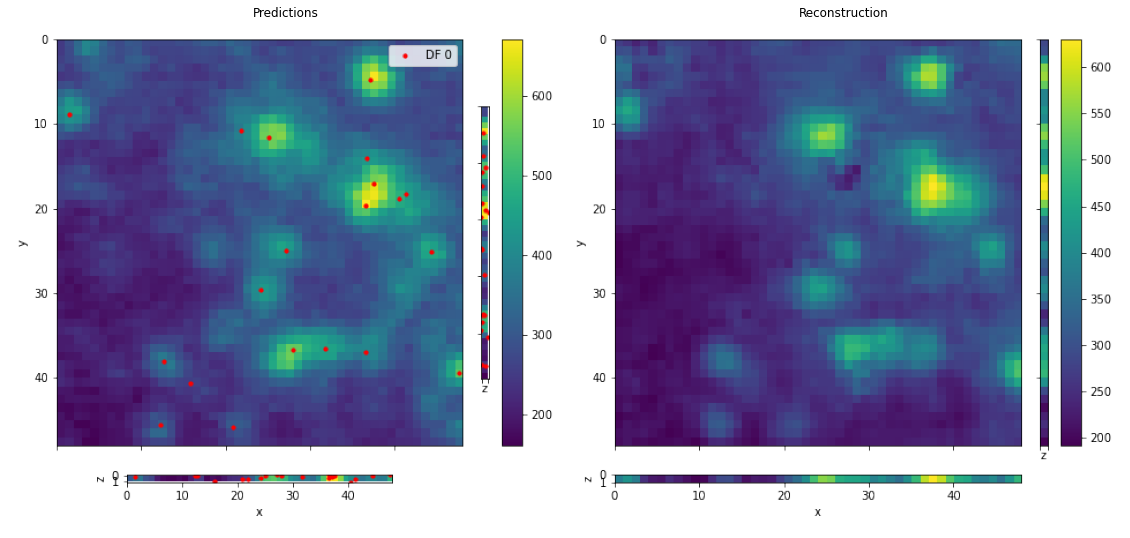

In [152]:
x, local_rate, background, pred_df, rec, res_dict, psf_recs, psf_bgs, rois, ch_inp = eval_random_crop(decode_dl, model, post_proc, micro, plot='rec', crop_sz_xy=100, ret_preds=True)

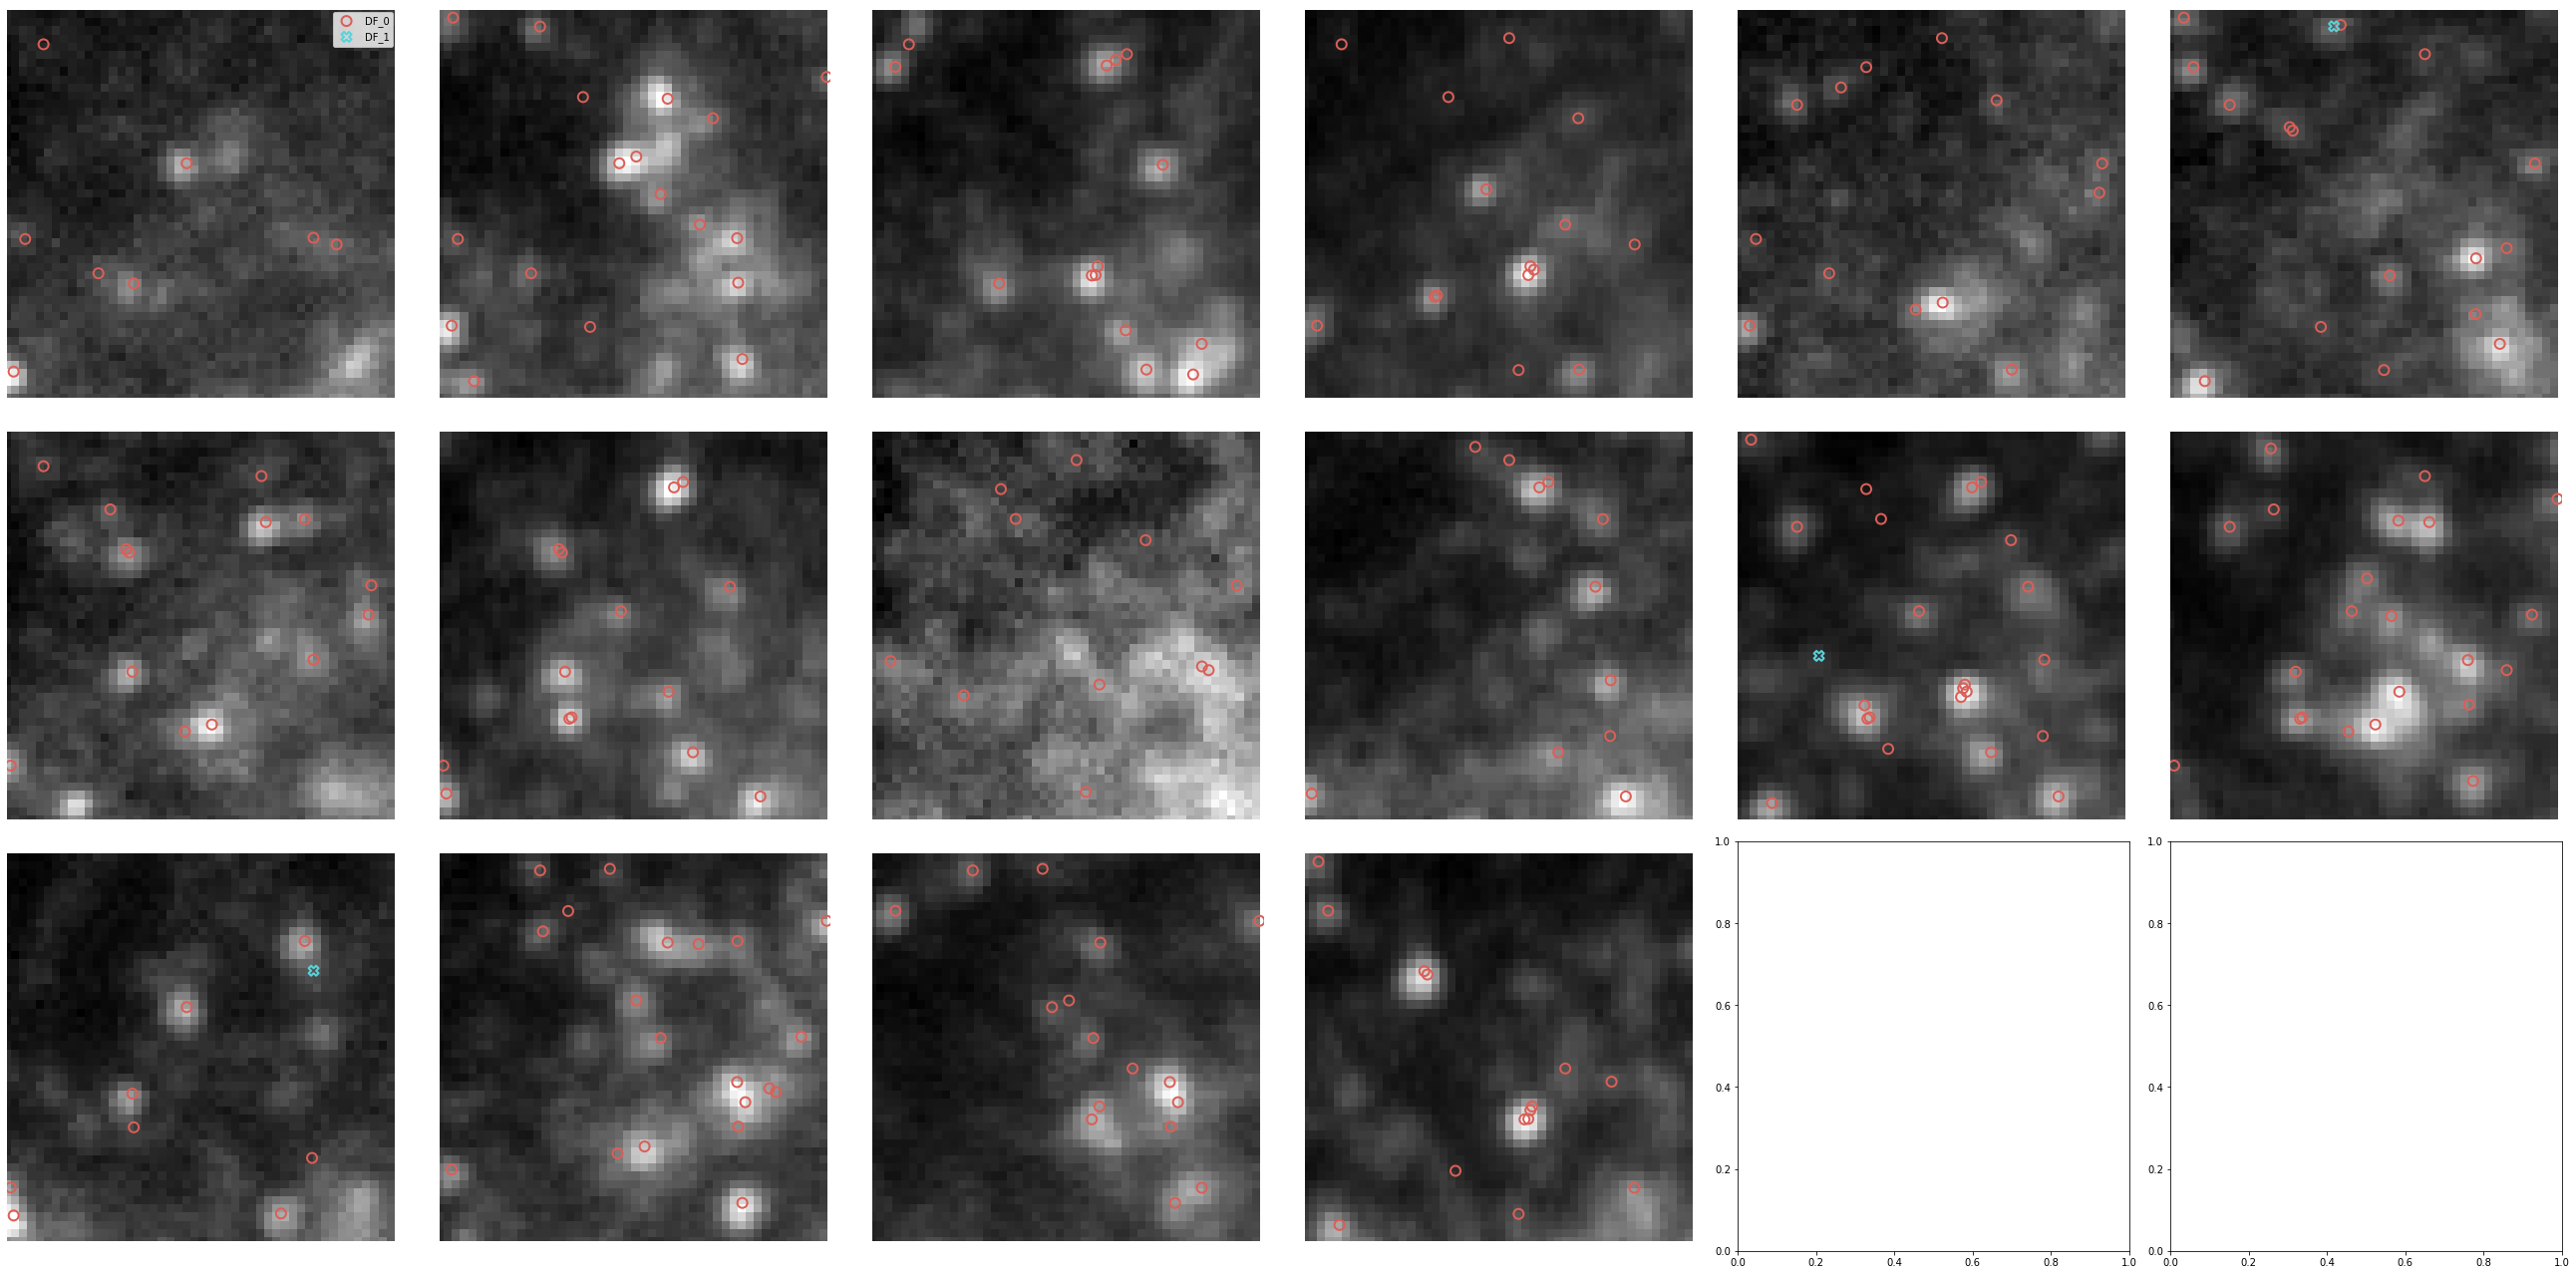

In [153]:
_ = plot_channels(x, dfs=[pred_df[pred_df['code_inds']<len(codebook)], pred_df[pred_df['code_inds']>len(codebook)]], n_rows=3, codebook=post_proc.codebook,sc_sz=100)

In [313]:
code_weight = torch.ones(len(post_proc.codebook))
code_weight[len(codebook):] *= cfg.genm.emitter_noise.rate_fac
point_process = PointProcessUniform(int_conc=model.int_dist.int_conc.detach(), int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                   sim_iters=5, n_channels=cfg.genm.exp_type.n_channels, sim_z=cfg.genm.exp_type.pred_z, slice_rec=cfg.genm.exp_type.slice_rec, 
                                    codebook=post_proc.codebook, int_option=cfg.training.int_option, code_weight=code_weight)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/point_process.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.codebook = torch.tensor(codebook).to(self.device) if codebook is not None else None


In [314]:
from decode_fish.funcs.routines import *
xsim, cols, gt = sim_data(decode_dl, micro, point_process, 20, n_codes=len(codebook), rate_fac=1.5, pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z)

In [315]:
pred_dfs = []
net_inp = torch.concat([xsim,cols], 1)
for i in range(len(net_inp)):
    pred_df = get_prediction(model, net_inp[i:i+1], post_proc, cuda=True)
    pred_dfs.append(pred_df)

pred_df = cat_emitter_dfs(pred_dfs)

In [325]:
perf, matches, _ = matching(px_to_nm(gt, cfg.evaluation.px_size_zyx), pred_df, tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.528
Precision: 0.957
Jaccard: 51.586
RMSE_vol: 59.038
Eff_3d: 43.296
FN: 36156.0 FP: 1805.0
Num. matches: 40448.000
Shift: 0.47,0.11,0.94


In [326]:
# perf, matches, _ = matching(px_to_nm(gt[gt['code_inds']>140], cfg.evaluation.px_size_zyx), pred_df[pred_df['code_inds']>140], tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

In [327]:
pred_df.loc[:, 'class'] = 1
pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
print(pred_df.loc[:, 'class'].sum() / len(pred_df))

0.04271886019927579


In [328]:
pred_df = zero_int_ch(pred_df, post_proc.codebook)

In [329]:
code_df = pred_df[pred_df['code_inds']<140]

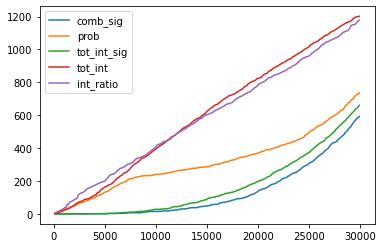

In [330]:
for k in ['comb_sig','prob','tot_int_sig', 'tot_int', 'int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(code_df, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
plt.legend()

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [337]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

keys = ['comb_sig','int_ratio']

X = np.concatenate([res_single[keys].values])
y = np.concatenate([res_single['class'].values])
 
clf = LogisticRegressionCV(random_state=1,max_iter=10000, class_weight='balanced').fit(X, y)

In [338]:
X = np.concatenate([pred_df[keys].values])
pred_df['score'] = clf.predict_proba(X)[:,1]
clf.coef_[0]

array([0.64620086, 4.00994765])

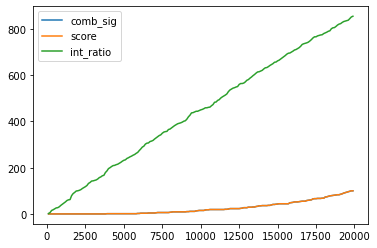

In [339]:
for k in ['comb_sig','score','int_ratio']:
    r  = make_roc(pred_df, k, n_max=20000, ascending=True)
    plt.plot(r[0],r[1], label=k)
plt.legend()

### Real data inference

In [299]:
res_df = window_predict(model, post_proc, decode_dl.dataset.volumes, window_size=[None, 256, 256], device='cuda', chrom_map=get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx)[:,:,None], scale=micro.get_ch_mult())
res_df = exclude_borders(res_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])

torch.Size([1, 16, 1, 2048, 2048])


In [300]:
all_df = res_df.copy()
sel = res_df['code_inds']<len(codebook)
print(sum(sel), len(res_df)/sum(sel))
res_df = res_df[sel]

31952 1.0724211316975463


In [301]:
int_arr = zero_int_ch(res_df, codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
ch_means2 = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(16)]
np.sqrt(np.var(ch_means2))

0.032001571367768857

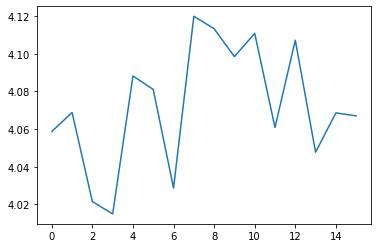

In [302]:
plt.plot(ch_means2)

In [303]:
from decode_fish.funcs.merfish_eval import *
bench_df = get_starfish_benchmark()
bench_df = bench_df[bench_df['gene'] != 'MALAT1']
bench_df['class'] = bench_df['gene'].str.contains('Blank')

13832


In [304]:
res_df['gene'] = targets[res_df['code_inds']]
res_df['class'] = res_df['gene'].str.contains('Blank')
res_df = res_df[res_df['gene'] != 'MALAT1'] 
res_df['x'] += 100
res_df['y'] += 100

In [305]:
# Filter out xy across frames (because same emitter could be in two adjacent slices)
# Different PSFs for different slices? (oil objective makes PSF dependent on)

In [306]:
res_single = remove_doublets(res_df, tolerance=200)
print(len(res_single)/len(res_df))
res_single = sel_int_ch(res_single, codebook)
X = np.concatenate([res_single[keys].values])
res_single['score'] = clf.predict_proba(X)[:,1]

0.9428320734341252


NameError: name 'keys' is not defined

In [307]:
matches, _, _ = matching(res_single.nsmallest(14000, 'int_ratio'), bench_df)

Recall: 0.679
Precision: 0.757
Jaccard: 55.748
RMSE_vol: 111.638
Eff_3d: 28.768
FN: 4495.0 FP: 3050.0
Num. matches: 9505.000
Shift: -6.01,-8.07,19.80


In [279]:
matches, _, _ = matching(res_single.nsmallest(14000, 'int_ratio'), bench_df)

Recall: 0.676
Precision: 0.754
Jaccard: 55.383
RMSE_vol: 109.299
Eff_3d: 29.451
FN: 4535.0 FP: 3090.0
Num. matches: 9465.000
Shift: -4.09,-2.77,4.53


12555 27938


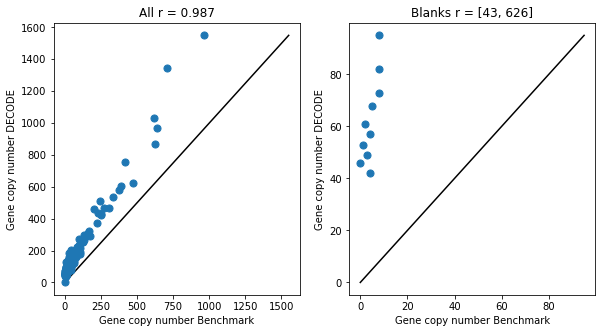

In [308]:
plot_gene_panels(res_single, bench_df, targets)

12555 12555


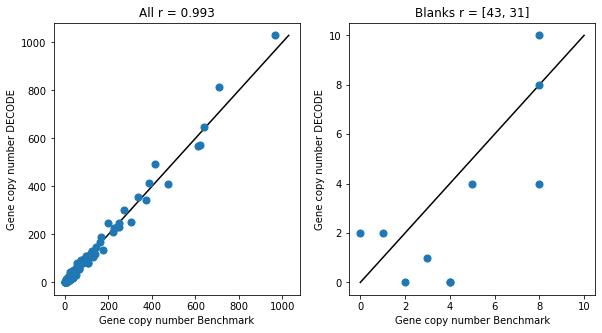

In [309]:
plot_gene_panels(res_single.nsmallest(12555, 'comb_sig'), bench_df, targets)

12555 12555


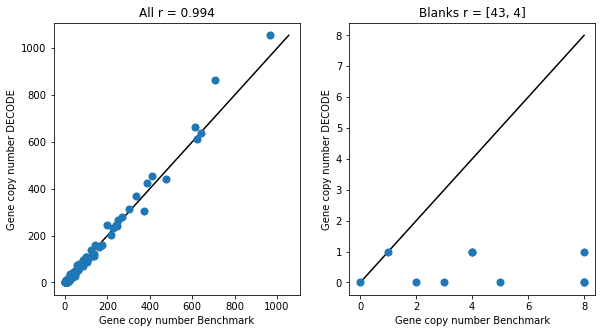

In [310]:
plot_gene_panels(res_single.nsmallest(12555, 'int_ratio'), bench_df, targets)

In [311]:
ist_df = get_istdeco()
ist_df = ist_df[ist_df['gene'] != 'MALAT1']
ist_df['class'] = ist_df['gene'].str.contains('Blank')

156501


(array([6.674e+03, 9.814e+03, 8.933e+03, 2.226e+03, 2.080e+02, 4.500e+01,
        2.100e+01, 7.000e+00, 6.000e+00, 4.000e+00]),
 array([0.06264605, 0.25101182, 0.43937758, 0.6277433 , 0.81610906,
        1.0044749 , 1.1928406 , 1.3812064 , 1.5695721 , 1.7579379 ,
        1.9463036 ], dtype=float32),
 <BarContainer object of 10 artists>)

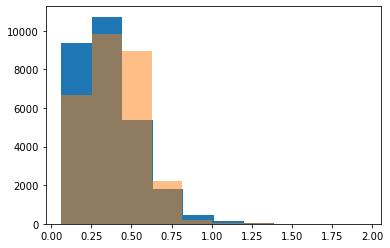

In [334]:
plt.hist(res_single['comb_sig'])
plt.hist(res_single['tot_int_sig']/10, alpha=0.5)

(0.0, 100.0)

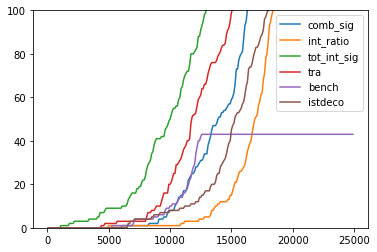

In [336]:
for k in ['comb_sig','int_ratio', 'tot_int_sig','z']:
    r  = make_roc(res_single, k, n_max=25000, ascending=True)
    plt.plot(r[0],r[1], label=k)
r  = make_roc(bench_df, 'total_magnitude', n_max=25000, ascending=False)
plt.plot(r[0],r[1], label='bench')
r  = make_roc(ist_df, 'quality', n_max=25000, ascending=False)
plt.plot(r[0],r[1], label='istdeco')
plt.legend()
plt.ylim(0,100)

27631


(600.0, 750.0)

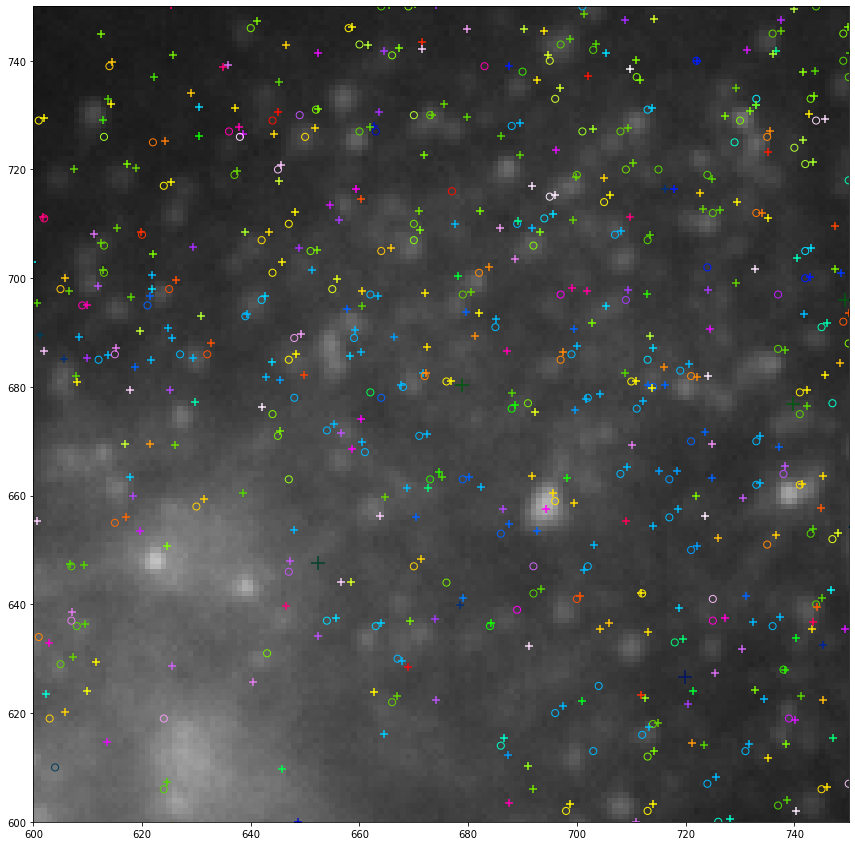

In [264]:
code_cols = [plt.get_cmap('gist_ncar')(x) for x in np.linspace(0.,1.,140)]

ind = 0
img = load_tiff_image(cfg.data_path.image_path)
preds_px = nm_to_px(res_single)#[res_df['gene']!='MALAT1']
bench_px = nm_to_px(bench_df)#[bench_df['gene']!='MALAT1']
print(len(preds_px))
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img[0,0], cmap='gray')

for i in range(len(targets)):
    
    preds_sub = preds_px[preds_px['code_inds'] == i]
    bench_sub = bench_px[bench_px['code_inds'] == i]
    
    size = 200. if 'Blank' in targets[i] else 50.

    ax.scatter(bench_sub['x'],bench_sub['y'], color=code_cols[i], s=size, marker='o', facecolor='none')
    ax.scatter(preds_sub['x'],preds_sub['y'], color=code_cols[i], s=size, marker='+')

ax.set_xlim(600,750)
ax.set_ylim(600,750)

# plugins.connect(fig, plugins.MousePosition(fontsize=14))
# mpld3.display()

## Compare distribution of metrics for blanks

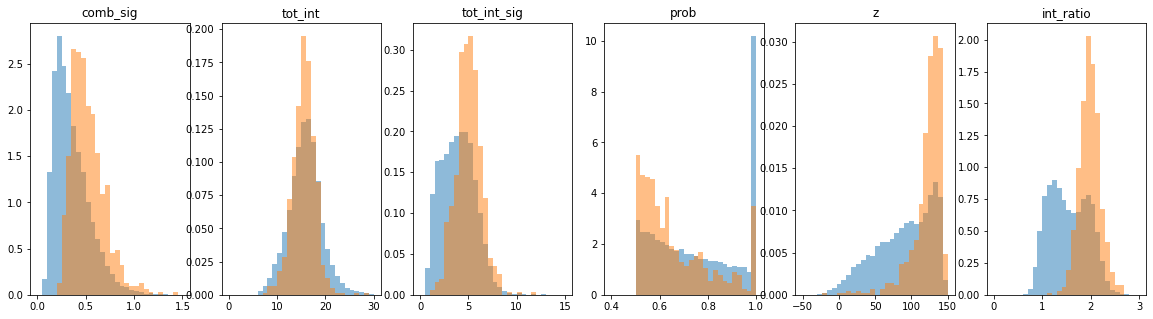

In [340]:
# res_single = sel_int_ch(res_single, codebook)
metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,3., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_single[~res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_single[res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [209]:
for i in range(4):
    for j in range(i+1,4):
        print(i,j,np.corrcoef(res_single[f'int_{i}'], res_single[f'int_{j}'])[0,1])

0 1 0.36550936491897
0 2 0.35345916893527335
0 3 0.33948671087577964
1 2 0.3158839088407401
1 3 0.2784189470864418
2 3 0.31423482597491453


In [390]:
res_single = remove_doublets(res_df, tolerance=200)

In [391]:
iks = [f'int_{i}' for i in range(16)]
fs = res_single[iks].values.sum(-1) - zero_int_ch(res_single, codebook)[iks].values.sum(-1)
ps = zero_int_ch(res_single, codebook)[iks].values.sum(-1)
res_single['omg'] = fs/ps

In [402]:
res_single['omg'] = fs/ps

In [348]:
code_df = sel_int_ch(code_df,codebook)

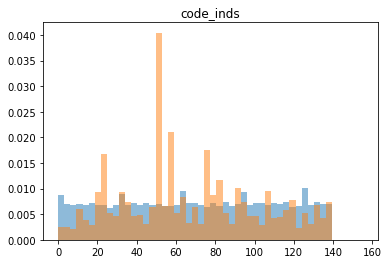

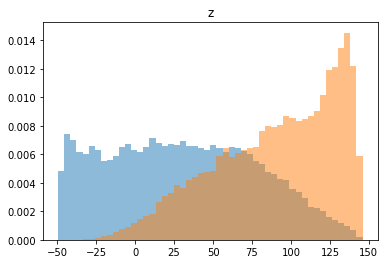

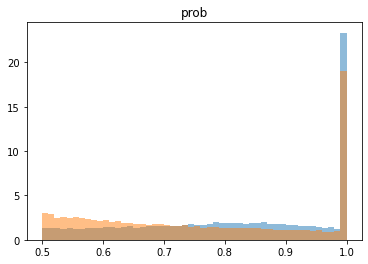

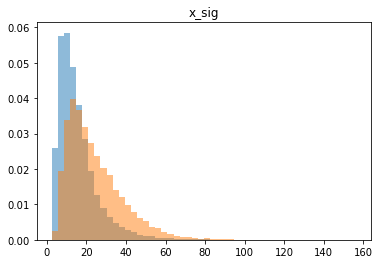

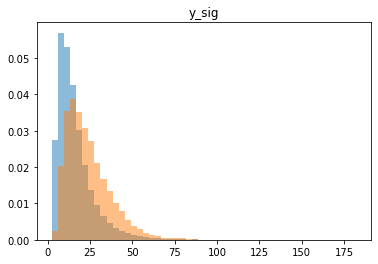

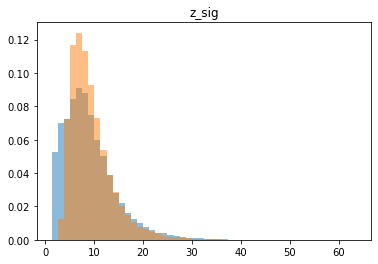

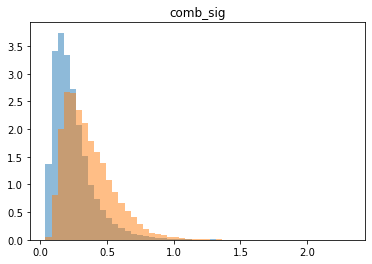

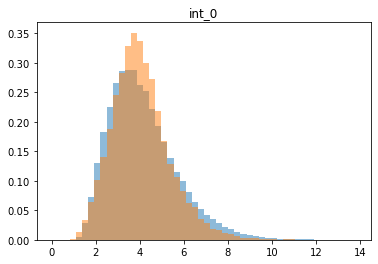

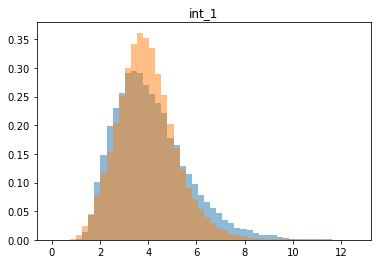

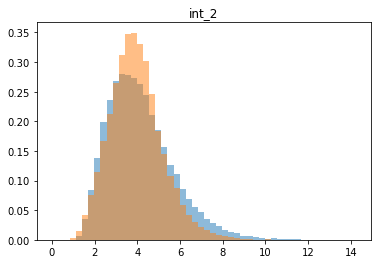

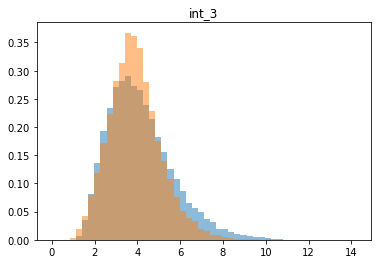

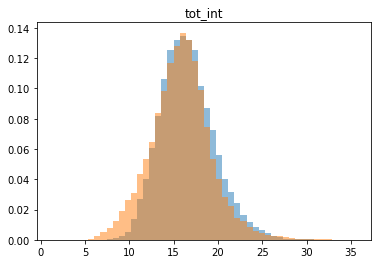

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


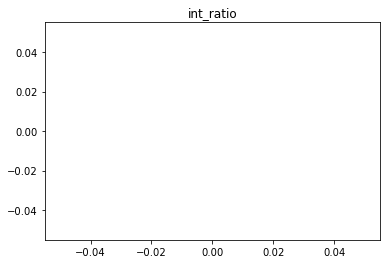

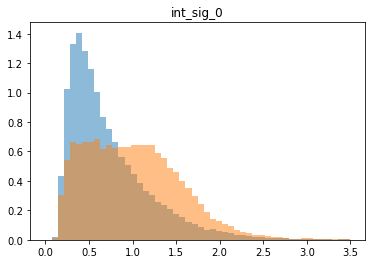

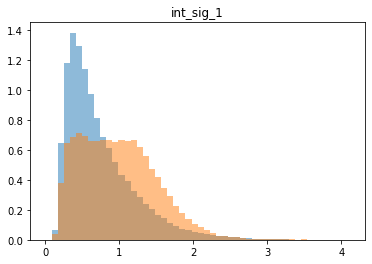

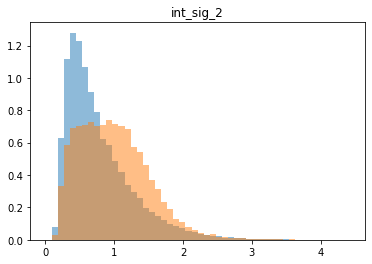

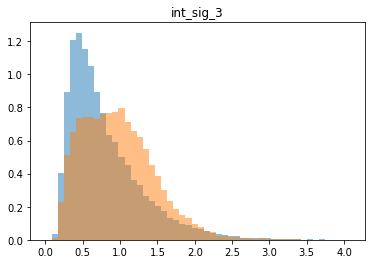

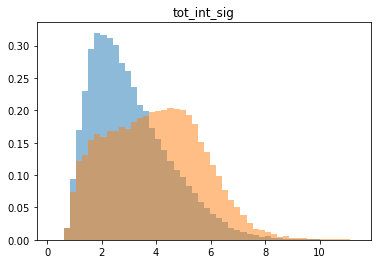

In [349]:
# tra = sel_int_ch(pred_df, codebook)
for k in res_single.keys():
    if k not in ['loc_idx','frame_idx','class','gene','score','x','y']:
        if k in code_df and k in res_single:
            bins = np.linspace(pred_df[k].min(), pred_df[k].max(), 51)
            plt.hist(code_df[k], alpha=0.5, bins=bins, density=True)
            plt.hist(res_single[k], alpha=0.5, bins=bins, density=True)
            plt.title(k)
            plt.show()